In [1]:
import napari
import glob
import os
from tifffile import imread
import numpy as np
import pandas as pd

from tifffile import imwrite

from skimage.util import img_as_ubyte
from PIL import Image, ImageDraw, ImageFont
from skimage import draw

from matplotlib import pyplot as plt
path = '/run/media/loaloa/lbb_ssd/primitives/'

In [2]:
with napari.gui_qt():
    viewer = napari.Viewer()

In [3]:
all_files = pd.read_csv(f'{path}/processed2/file_index.csv', index_col=(0,1,2,3))
primitives = all_files.index.unique(0)
print(primitives)
divs = all_files.index.unique(1)
print(divs)
print()

prim = primitives[6]
div = divs[0]
lbl = f'{prim}_{div}'
dest_dir = f'{path}/processed2/results/{lbl}_masks/'

print('Processing now: ', lbl)

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/loaloa/programs/anaconda3/envs/bioMEA/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/home/loaloa/programs/anaconda3/envs/bioMEA/lib/python3.8/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/loaloa/programs/anaconda3/envs/bioMEA/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/loaloa/programs/anaconda3/envs/bioMEA/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(80, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(80, 1)>
Traceback (most recent call last):
  

In [4]:
files = all_files.loc[(prim, div)].values.flatten()
print(files)

png_images = [np.asarray(Image.open(f)) for f in files]
npy_images = [np.load(f.replace('.png', '.npy')) for f in files]

to_yshape = np.max([i.shape[0] for i in npy_images])
png_images = [np.pad(im, ((to_yshape-im.shape[0],0), (0,0), (0,0)), mode='constant') for im in png_images]
npy_images = [np.pad(im, ((to_yshape-im.shape[0],0), (0,0), (0,0)), mode='constant') for im in npy_images]

png_prim_im = np.concatenate(png_images, 1)
npy_prim_im = np.concatenate(npy_images, 1)[...,:2].astype(float) /2**16

print(npy_prim_im.shape)


viewer.add_image(png_prim_im, name=prim+'_'+div)
# viewer.add_image(npy_prim_im, name='npy'+prim+div)

['/run/media/loaloa/lbb_ssd/primitives//processed2/exp12_DIV14_processed_Prim05_G002.png'
 '/run/media/loaloa/lbb_ssd/primitives//processed2/exp14_DIV14_processed_Prim05_G006.png']
(7345, 1190, 2)


<Image layer 'Prim05_DIV14' at 0x7f3a880f6df0>

In [12]:
add_n_shape_layers = 8
for i in range(1, add_n_shape_layers+1):
    viewer.add_labels(np.zeros(png_prim_im.shape[:2], int), name=f'{lbl}_{i:0>2}_lbl')
    # break

In [5]:
layers = [np.load(f) for f in glob.glob(f'{path}/processed2/results/{lbl}_masks/*_mask.npy')]
[viewer.add_labels(dat, name=f'{lbl}_{i:0>2}_lbl') for i, dat in enumerate(layers)]
[print(d.shape) for d in layers]

(7345, 1190)
(7345, 1190)
(7345, 1190)
(7345, 1190)
(7345, 1190)
(7345, 1190)
(7345, 1190)
(7345, 1190)


[None, None, None, None, None, None, None, None]

In [13]:
os.makedirs(dest_dir, exist_ok=True)
layers = [l for l in viewer.layers if l.name.endswith('_lbl')]
print(len(layers))
[np.save(f'{dest_dir}/{l.name}_mask.npy', l.data) for l in layers]

all_masks = np.stack([l.data.copy() for l in layers], axis=-1).sum(-1)
u = np.unique(all_masks, return_counts=True)
u


8


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 array([8690527,   10756,    1846,    1740,    1671,    2247,    2594,
           2171,    1805,    2439,   10682,    1681,    1643,    1123,
           1355,     931,    1290,    2186,    1863]))

In [24]:
design_namemap = {               # r     $d
    # 'Prim01.1': {

    # }.

    'Prim04': {
        7: '10_spikes',
        6: '06_spikes',
        5: '04_spikes',
        4: '02_spikes',
        3: 'neg_control',
        2: '10_hills',
        1: '04_hilld',
        0: '02_hills',
    },
    'Prim05': {
        1: 'backward stomache',

        2: 'backward rescue loops',
        3: 'forward rescue loops',

        4: 'backward negative control',
        5: 'forward negative control',

        6: 'forward rescue loops angled',
        7: 'backward rescue loops angled',

        8: 'forward stomache',
    },
}

min_int_thr = .04
min_seg_area_size = 120

# Prim2
n_variants = 32
unit_size = 2
# Prim2
n_variants = 32
unit_size = 2
# Prim2
n_variants = 32
unit_size = 2



# Prim05
n_variants = 2
unit_size = 9

In [10]:
# Prim 01, 04 

data = []
confirmation_canvas = np.zeros_like(png_prim_im, float)
confirmation_mask = np.zeros(png_prim_im.shape[:2], int)
for i in range(len(layers)):
    print('layer ', i, end='...   ')
    dat = layers[i].data
    
    for j in range(n_variants):
        for k in range(unit_size):
            mask_idx = j*unit_size +k +1
            mask = dat==mask_idx

            channel_region = npy_prim_im[mask]
            if mask.sum() > min_seg_area_size:
                median_int = np.median(channel_region, 0)
            else:
                median_int = [0, 0]

            confirmation_canvas[mask, 0] = median_int[0]
            confirmation_canvas[mask, 1] = median_int[1]

            if k == 0:
                channel = 'inlet'
                confirmation_mask[mask] = 1
            elif k == 1:
                channel = 'straight'
                confirmation_mask[mask] = 2
            elif k == 2:
                channel = 'turn'
                confirmation_mask[mask] = 3

            
            idx = pd.MultiIndex.from_tuples(((j, i, channel, 'RFP'), (j, i, channel, 'GFP')), 
                                            name=('design','replicate', 'channel', 'color'))
            data.append(pd.Series(median_int, index=idx, name=(lbl)))

# viewer.add_image(confirmation_canvas, blending='additive', contrast_limits=(0,.05))
confirmation_canvas[confirmation_canvas<min_int_thr] = 0
viewer.add_image(confirmation_canvas, blending='additive', contrast_limits=(0,.05))
imwrite(f'{dest_dir}/segmentation_overview.png', img_as_ubyte(confirmation_canvas))

viewer.add_labels(confirmation_mask, blending='additive')

layer  0...   layer  1...   layer  2...   layer  3...   layer  4...   

KeyboardInterrupt: 

In [8]:
def draw_line(canvas, ystart_coo,xstart_coo, ystop_coo,xstop_coo, col=(.8,.8,.8)):
    confirmation_canvas[draw.line(ystart_coo, xstart_coo, ystop_coo, xstop_coo)] = col
    confirmation_canvas[draw.line(ystart_coo, xstart_coo+1, ystop_coo, xstop_coo+1)] = col
    confirmation_canvas[draw.line(ystart_coo, xstart_coo-1, ystop_coo, xstop_coo-1)] = col

In [13]:
# Prim 02

data = []
confirmation_canvas = np.zeros_like(png_prim_im, float)
for i in range(len(layers)):
    print('layer ', i, end='...   ')
    dat = layers[i].data
    
    for j in range(n_variants):
        for k in range(unit_size):
            mask_idx = j*unit_size +k +1
            mask = dat==mask_idx
            if mask.sum() < min_seg_area_size:
                dist = np.nan
            
            else:
                y_coo = np.where(mask)[0].max()
                x_coo = np.where(mask)[1].mean().astype(int)
                if k == 0:
                    ystart_coo = y_coo.copy()
                    xstart_coo = x_coo.copy()
                elif k == 1:
                    dist = np.abs(ystart_coo - y_coo)
                    draw_line(confirmation_canvas, ystart_coo,xstart_coo, y_coo,x_coo, (.8,.8..8))
                
            idx = pd.MultiIndex.from_tuples(( (j, i), ), 
                                            name=('design','replicate'))
            data.append(pd.Series([dist], index=idx, name=(lbl)))


viewer.add_image(confirmation_mask, blending='additive')
imwrite(f'{dest_dir}/segmentation_overview.png', img_as_ubyte(confirmation_canvas))

SyntaxError: invalid syntax (3831859884.py, line 24)

In [16]:
# Prim 05
# valid datapaints needs to have a cl
# 1 start green, 2-9 
# 10 start red, 11-18 



data = []
confirmation_canvas = np.zeros_like(png_prim_im, float)
for i in range(len(layers)):
    print('layer ', i, end='...   ')
    dat = layers[i].data
    
    dists, replicate_lbls, design_lbls = [], [], []
    for j in range(n_variants):
        for k in range(unit_size):
            mask_idx = j*unit_size +k +1
            mask = dat==mask_idx

            if mask.sum() < min_seg_area_size:
                dist = np.nan
            else:
                y_coo = np.where(mask)[0].max()
                x_coo = np.where(mask)[1].max().astype(int)
                # take care of start line segmentation
                if k == 0:
                    ystart_coo = y_coo.copy()
                    xstart_coo = x_coo.copy()
                    if j == 0:
                        GFP_ystart_coo = ystart_coo.copy()
                        GFP_xstart_coo = xstart_coo.copy()
                    elif j == 1:
                        well_dist = np.sqrt((GFP_ystart_coo-ystart_coo)**2 + (GFP_xstart_coo-xstart_coo)**2)
                        print('Well dist: ', well_dist)
                        draw_line(confirmation_canvas, GFP_ystart_coo,GFP_xstart_coo, ystart_coo,xstart_coo)
                    continue
                else:
                    dist = np.abs(ystart_coo - y_coo)
                    col = (.8,.1,.1) if j else (.1,.8,.1)
                    draw_line(confirmation_canvas, ystart_coo,x_coo, y_coo,x_coo, col)
                
            if k:
                dists.append(dist)
                design = k if j==0 else unit_size-k
                replicate = j +i*2
                
                design_lbls.append(design)
                replicate_lbls.append(replicate)
    
    idx = pd.MultiIndex.from_tuples([(d, r) for d,r in zip(design_lbls, replicate_lbls)], 
                                    names=('design','replicate'))
    print(pd.Series(dists, index=idx, name=(lbl)) /well_dist)
    data.append(pd.Series(dists, index=idx, name=(lbl)) /well_dist)

viewer.add_image(confirmation_canvas, blending='additive', contrast_limits=(0,.05))
imwrite(f'{dest_dir}/segmentation_overview.png', img_as_ubyte(confirmation_canvas))

layer  0...   Well dist:  1069.0018709057529
design  replicate
1       0                 NaN
2       0                 NaN
3       0                 NaN
4       0            0.998127
5       0            0.856874
6       0            0.988773
7       0                 NaN
8       0                 NaN
        1                 NaN
7       1                 NaN
6       1                 NaN
5       1                 NaN
4       1            0.231057
3       1                 NaN
2       1            0.987837
1       1                 NaN
Name: Prim05_DIV14, dtype: float64
layer  1...   Well dist:  1064.0018796975878
design  replicate
1       2                 NaN
2       2                 NaN
3       2                 NaN
4       2            0.993419
5       2            0.994359
6       2                 NaN
7       2                 NaN
8       2            0.984021
        3            0.148496
7       3            0.064850
6       3                 NaN
5       3            0.201127

In [17]:
# Prim 01, 04
# data = pd.concat(data, axis=0).to_frame()
# data[data<min_int_thr] = 0
# data.to_csv(f'{dest_dir}/{lbl}_intensities.csv')


# Prim 02, 05
data = pd.concat(data, axis=0).to_frame()
data.columns = [prim]
data.to_csv(f'{dest_dir}/{lbl}_metrics.csv')

data

Prim05
design replicate          
1      0               NaN
2      0               NaN
3      0               NaN
4      0          0.998127
5      0          0.856874
...                    ...
       15         0.854138
4      15              NaN
3      15              NaN
2      15              NaN
1      15         0.010751

[128 rows x 1 columns]

In [18]:
# col = data.index.get_level_values(3)
# greens = data[col=='GFP']
# reds = data[col=='RFP']
# %matplotlib qt5
# plt.hist(reds, bins=150, alpha=.5, range=(0,.10))
# plt.hist(greens, bins=150, alpha=.5, range=(0,.10))


data.index.unique(0)

Int64Index([1, 2, 3, 4, 5, 6, 7, 8], dtype='int64', name='design')

In [17]:
# For Primitive 01, 04

def get_metric(which_metric, dat):
    inlet = dat[slice(None),slice(None),'inlet']
    straight = dat[slice(None),slice(None),'straight']
    turn = dat[slice(None),slice(None),'turn']

    if which_metric == 'diff_ratio':
        m = (straight-turn) /inlet
        if (inlet == 0).all():
            m.loc[:] = np.nan
    
    elif which_metric == 'diff_sumratio':
        m = (straight-turn) / (straight+turn)
        if (inlet == 0).all():
            m.loc[:] = np.nan

    elif which_metric == 'diff':
        m = (straight-turn)
    
    return m
    # m.index = pd.MultiIndex.from_tuples([(*m.index[0], 'metric'),], names=m.index.names+['inlet'])
    # return m.swaplevel()
    


which_metric = 'diff_sumratio'
# which_metric = 'diff'
all_metric = []
for datapoint in data.index.droplevel([2,3]).unique():
    
    col_metrics = []
    for color in data.index.unique('color'):
        col_dat = data.loc[(*datapoint, slice(None), color), lbl]
        col_metrics.append(get_metric(which_metric, col_dat))
        
    datapoint_metric = pd.concat(col_metrics).mean()
    idx = pd.MultiIndex.from_tuples([datapoint], names=data.index.names[:2])
    all_metric.append(pd.Series([datapoint_metric], index=idx, name=which_metric))


    

all_metrics = pd.concat(all_metric).to_frame()
all_metrics.to_csv(f'{dest_dir}/{lbl}_metrics.csv')
all_metrics

,,diff_sumratio
design,replicate,
0,0,0.293694
1,0,0.515257
2,0,NaN
3,0,0.719136
4,0,0.485681
...,...,...
3,7,-1.000000
4,7,-1.000000
5,7,-0.028141


In [ ]:

# =========== PRIM 1.1 ================

all_metrics = pd.read_csv(f'{dest_dir}/{lbl}_metrics.csv', index_col=(0,1)).iloc[:,0]
print(all_metrics)

%matplotlib inline

plt.title(lbl+' DESIGN')
for d in all_metrics.index.unique('design'):
    design_metrics = all_metrics[d]
    median = design_metrics.median()
    xlocs = [d]*len(design_metrics)
    
    plt.scatter(xlocs, design_metrics, s=10)
    plt.scatter(d, median, marker='_', s=500, color='k')

plt.figure()
plt.title(lbl+' RADIUS')
design_sets = ([0,1,2,3], [4,5,6,7], [8,9,10,11], [12])
for xloc, design_set in enumerate(design_sets):
    design_metrics = all_metrics[design_set]
    median = design_metrics.median()
    xlocs = [xloc]*len(design_metrics)

    plt.scatter(xlocs, design_metrics, s=10)
    plt.scatter(xloc, median, marker='_', s=500, color='k')

plt.figure()
plt.title(lbl+' OPENING DIAMETER')
design_sets = ([0,4,8], [1,5,9], [2,6,10], [3,7,11], [12])
for xloc, design_set in enumerate(design_sets):
    design_metrics = all_metrics[design_set]
    median = design_metrics.median()
    xlocs = [xloc]*len(design_metrics)

    plt.scatter(xlocs, design_metrics, s=10)
    plt.scatter(xloc, median, marker='_', s=500, color='k')


design  replicate
0       0                 NaN
1       0                 NaN
2       0                 NaN
3       0                 NaN
4       0                 NaN
                       ...   
1       15           0.931818
2       15           0.700000
3       15           1.145503
4       15           0.596048
5       15           0.116162
Name: diff_ratio, Length: 96, dtype: float64
0 3
1 2
2 1
3 0
4 4
5 5


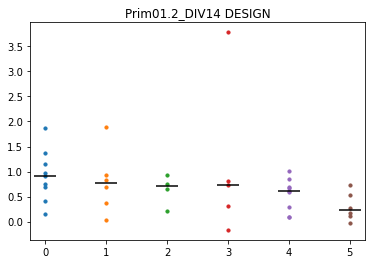

In [18]:

# =========== PRIM 1.2 ================

all_metrics = pd.read_csv(f'{dest_dir}/{lbl}_metrics.csv', index_col=(0,1)).iloc[:,0]
print(all_metrics)

designs = all_metrics.index.unique('design')
designs = [3,2,1,0,4,5]

%matplotlib inline

plt.title(lbl+' DESIGN')
for xloc, d in enumerate(designs):
    print(xloc, d)
    design_metrics = all_metrics[d]
    median = design_metrics.median()
    xlocs = [xloc]*len(design_metrics)
    
    plt.scatter(xlocs, design_metrics, s=10)
    plt.scatter(xloc, median, marker='_', s=500, color='k')

design  replicate
0       0            0.293694
1       0            0.515257
2       0                 NaN
3       0            0.719136
4       0            0.485681
                       ...   
3       7           -1.000000
4       7           -1.000000
5       7           -0.028141
6       7            1.000000
7       7            0.188268
Name: diff_sumratio, Length: 64, dtype: float64
0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7


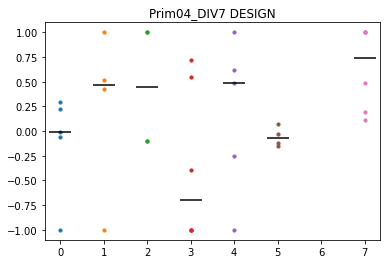

In [14]:

# =========== PRIM 2 ================

all_metrics = pd.read_csv(f'{dest_dir}/{lbl}_metrics.csv', index_col=(0,1)).iloc[:,0]
print(all_metrics)

designs = all_metrics.index.unique('design')
# designs = [3,2,1,0,4,5]

%matplotlib inline

plt.title(lbl+' DESIGN')
for xloc, d in enumerate(designs):
    print(xloc, d)
    design_metrics = all_metrics[d]
    if design_metrics.notna().sum() < 4:
        continue
    median = design_metrics.median()
    xlocs = [xloc]*len(design_metrics)
    
    plt.scatter(xlocs, design_metrics, s=10)
    plt.scatter(xloc, median, marker='_', s=500, color='k')

design  replicate
0       0            0.293694
1       0            0.515257
2       0                 NaN
3       0            0.719136
4       0            0.485681
                       ...   
3       7           -1.000000
4       7           -1.000000
5       7           -0.028141
6       7            1.000000
7       7            0.188268
Name: diff_sumratio, Length: 64, dtype: float64
[3, 0, 1, 2, 4, 5, 6, 7]
3 0 neg_control
0 1 02_hills
1 2 04_hilld
2 3 10_hills
4 4 02_spikes
5 5 04_spikes
6 6 06_spikes
7 7 10_spikes


[Text(0, 0, 'neg_control'),
 Text(1, 0, '02_hills'),
 Text(2, 0, '04_hilld'),
 Text(3, 0, '10_hills'),
 Text(4, 0, '02_spikes'),
 Text(5, 0, '04_spikes'),
 Text(6, 0, '06_spikes'),
 Text(7, 0, '10_spikes')]

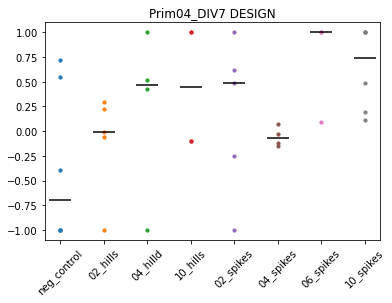

In [18]:
# =========== PRIM 04 ================

all_metrics = pd.read_csv(f'{dest_dir}/{lbl}_metrics.csv', index_col=(0,1)).iloc[:,0]
print(all_metrics)

designs = all_metrics.index.unique('design')
designs = [3, 0,1,2,4,5,6,7]
print(designs)

%matplotlib inline

plt.title(lbl+' DESIGN')
xlbls = []
for xloc, d in enumerate(designs):
    xlbls.append(design_namemap[prim][d])
    print(d, xloc, design_namemap[prim][d])
    
    design_metrics = all_metrics[d]
    median = design_metrics.median()
    xlocs = [xloc]*len(design_metrics)
    
    plt.scatter(xlocs, design_metrics, s=10)
    plt.scatter(xloc, median, marker='_', s=500, color='k')

plt.gca().set_xticks(np.arange(len(designs)))
plt.gca().set_xticklabels(xlbls, rotation=45)

             Prim05                                                          \
replicate        0         1         2         3   4   5   6   7         8    
design                                                                        
1               NaN       NaN       NaN  0.015977 NaN NaN NaN NaN  0.009460   
2               NaN  0.987837       NaN  0.999998 NaN NaN NaN NaN  0.484815   
3               NaN       NaN       NaN  0.122180 NaN NaN NaN NaN  0.859659   
4          0.998127  0.231057  0.993419       NaN NaN NaN NaN NaN  0.994462   
5          0.856874       NaN  0.994359  0.201127 NaN NaN NaN NaN  0.571135   
6          0.988773       NaN       NaN       NaN NaN NaN NaN NaN  0.982637   
7               NaN       NaN       NaN  0.064850 NaN NaN NaN NaN  0.297984   
8               NaN       NaN  0.984021  0.148496 NaN NaN NaN NaN  0.992097   

                                                                     
replicate        9         10  11        12  13        14   

[Text(0, 0, 'backward stomache'),
 Text(1, 0, 'backward rescue loops'),
 Text(2, 0, 'forward rescue loops'),
 Text(3, 0, 'backward negative control'),
 Text(4, 0, 'forward negative control'),
 Text(5, 0, 'forward rescue loops angled'),
 Text(6, 0, 'backward rescue loops angled'),
 Text(7, 0, 'forward stomache')]

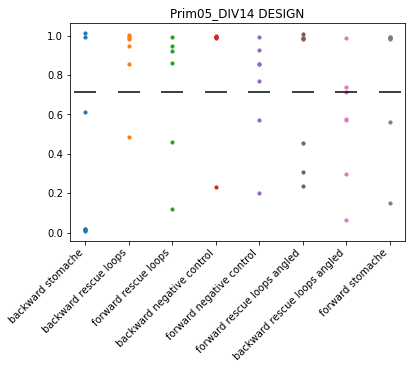

In [27]:
# =========== PRIM 05 ================

all_metrics = pd.read_csv(f'{dest_dir}/{lbl}_metrics.csv', index_col=(0,1)).iloc[:,0]
print(all_metrics.to_frame().unstack())

designs = all_metrics.index.unique('design')
print(designs)

# %matplotlib inline

plt.title(lbl+' DESIGN')
xlbls = []
for xloc, d in enumerate(designs):
    print(d)
    xlbls.append(design_namemap[prim][d])
    print(d, xloc, design_namemap[prim][d])
    
    design_metrics = all_metrics[d]
    # design_metrics[design_metrics>.9] = 1
    # design_metrics[design_metrics<.9] = 0
    # median = design_metrics.mean()

    median = design_metrics.median()
    xlocs = [xloc]*len(design_metrics)
    
    plt.scatter(xlocs, design_metrics, s=10)
    plt.scatter(xloc, median, marker='_', s=500, color='k')

plt.gca().set_xticks(np.arange(len(designs)))
plt.gca().set_xticklabels(xlbls, rotation=45, ha='right')